<a href="https://colab.research.google.com/github/auriwan/Recommendation-system/blob/main/Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import drive

In [2]:
!pip install -q kaggle

In [3]:
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [4]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/"

In [5]:
!chmod 600 /content/gdrive/MyDrive/kaggle.json

In [6]:
! KAGGLE_CONFIG_DIR=/content/gdrive/MyDrive kaggle datasets download -d hernan4444/anime-recommendation-database-2020

 98% 647M/661M [00:04<00:00, 146MB/s]
100% 661M/661M [00:04<00:00, 165MB/s]


In [7]:
file = '/content/anime-recommendation-database-2020.zip'
zip_ref = zipfile.ZipFile(file, 'r')
zip_ref.extractall('/dataset_baru/')
zip_ref.close()

In [8]:
df_anime = pd.read_csv('/dataset_baru/anime.csv')
df_rating = pd.read_csv('/dataset_baru/rating_complete.csv')

df_anime.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [9]:
df_anime.sort_values(by=['MAL_ID'], inplace=True, ascending=True)
df_anime

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17557,48481,Daomu Biji Zhi Qinling Shen Shu,Unknown,"Adventure, Mystery, Supernatural",Unknown,盗墓笔记之秦岭神树,ONA,Unknown,"Apr 4, 2021 to ?",Unknown,...,Unknown,Unknown,Unknown,1.0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
17558,48483,Mieruko-chan,Unknown,"Comedy, Horror, Supernatural",Unknown,見える子ちゃん,TV,Unknown,2021 to ?,Unknown,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
17559,48488,Higurashi no Naku Koro ni Sotsu,Unknown,"Mystery, Dementia, Horror, Psychological, Supe...",Higurashi:When They Cry – SOTSU,ひぐらしのなく頃に卒,TV,Unknown,"Jul, 2021 to ?",Summer 2021,...,1.0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
17560,48491,Yama no Susume: Next Summit,Unknown,"Adventure, Slice of Life, Comedy",Unknown,ヤマノススメ Next Summit,TV,Unknown,Unknown,Unknown,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown


In [10]:
df_rating

,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9
...,...,...,...
57633273,353404,502,8
57633274,353404,987,4
57633275,353404,225,8
57633276,353404,243,7


In [11]:
df_anime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17562 entries, 0 to 17561
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MAL_ID         17562 non-null  int64 
 1   Name           17562 non-null  object
 2   Score          17562 non-null  object
 3   Genres         17562 non-null  object
 4   English name   17562 non-null  object
 5   Japanese name  17562 non-null  object
 6   Type           17562 non-null  object
 7   Episodes       17562 non-null  object
 8   Aired          17562 non-null  object
 9   Premiered      17562 non-null  object
 10  Producers      17562 non-null  object
 11  Licensors      17562 non-null  object
 12  Studios        17562 non-null  object
 13  Source         17562 non-null  object
 14  Duration       17562 non-null  object
 15  Rating         17562 non-null  object
 16  Ranked         17562 non-null  object
 17  Popularity     17562 non-null  int64 
 18  Members        17562 non-n

In [12]:
df_anime = df_anime[['MAL_ID', 'Name', 'Genres']]
df_anime.head()

,MAL_ID,Name,Genres
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space"
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space"
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen"
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, ..."
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural"


In [13]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57633278 entries, 0 to 57633277
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 1.3 GB


In [14]:
df_rating.rating.value_counts()

8     14642156
7     13325549
9      9773857
6      6849293
10     6716048
5      3436250
4      1455102
3       696048
2       405556
1       333419
Name: rating, dtype: int64

In [15]:
print(f'Jumlah data Anime sebanyak {df_anime.shape[0]}, dan memiliki {df_anime.shape[1]} kolom')
print(f'Jumlah data Rating sebanyak {df_rating.shape[0]}, dan memiliki {df_rating.shape[1]} kolom')

Jumlah data Anime sebanyak 17562, dan memiliki 3 kolom
Jumlah data Rating sebanyak 57633278, dan memiliki 3 kolom


In [16]:
df_anime.isnull().sum()

MAL_ID    0
Name      0
Genres    0
dtype: int64

In [17]:
df_anime_clean = df_anime.dropna()
df_anime_clean.isnull().sum()

MAL_ID    0
Name      0
Genres    0
dtype: int64

In [18]:
df_rating.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [19]:
df_anime_clean.duplicated().sum()

0

In [20]:
df_rating.duplicated().sum()

0

In [21]:
df_rating.drop_duplicates(keep = False, inplace = True)

In [22]:
df_anime_clean.nunique()

MAL_ID    17562
Name      17558
Genres     5034
dtype: int64

In [23]:
df_rating.nunique()

user_id     310059
anime_id     16872
rating          10
dtype: int64

In [24]:
anime_genre = df_anime_clean.copy()
genres = []
for i in range(len(df_anime_clean.Genres)):
    for x in df_anime_clean.Genres[i].split(', '):
        if x not in genres:
            genres.append(x)
genres

['Action',
 'Adventure',
 'Comedy',
 'Drama',
 'Sci-Fi',
 'Space',
 'Mystery',
 'Shounen',
 'Police',
 'Supernatural',
 'Magic',
 'Fantasy',
 'Sports',
 'Josei',
 'Romance',
 'Slice of Life',
 'Cars',
 'Seinen',
 'Horror',
 'Psychological',
 'Thriller',
 'Super Power',
 'Martial Arts',
 'School',
 'Ecchi',
 'Vampire',
 'Military',
 'Historical',
 'Dementia',
 'Mecha',
 'Demons',
 'Samurai',
 'Game',
 'Shoujo',
 'Harem',
 'Music',
 'Shoujo Ai',
 'Shounen Ai',
 'Kids',
 'Hentai',
 'Parody',
 'Yuri',
 'Yaoi',
 'Unknown']

In [25]:
for x in genres:
    anime_genre[x] = 0

for i in range(len(df_anime_clean.Genres)):
    for x in df_anime_clean.Genres[i].split(', '):
        anime_genre[x][i]=1

anime_genre.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,MAL_ID,Name,Genres,Action,Adventure,Comedy,Drama,Sci-Fi,Space,Mystery,...,Harem,Music,Shoujo Ai,Shounen Ai,Kids,Hentai,Parody,Yuri,Yaoi,Unknown
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space",1,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, ...",1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural",0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


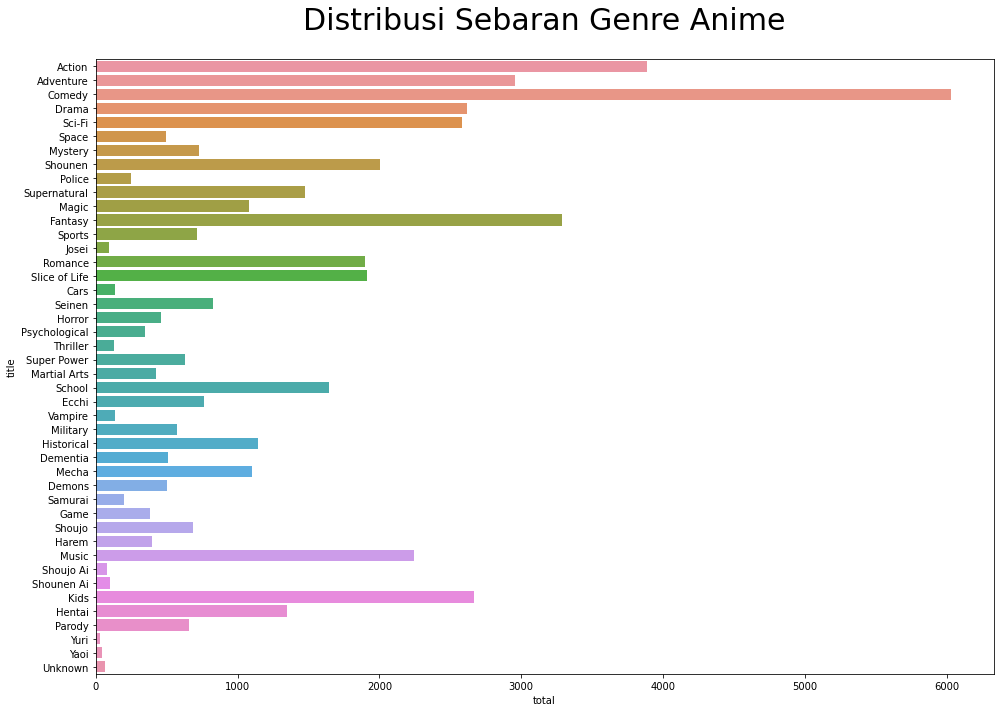

In [26]:
data = anime_genre.iloc[:,3:].sum().reset_index()
data.columns = ['title','total']

plt.figure(figsize=(14,10))
sns.barplot(y='title', x='total', data=data)
plt.title('Distribusi Sebaran Genre Anime', fontsize=30, pad=30)
plt.tight_layout()
plt.show()

In [27]:
print(f'Jumlah pengguna yang memberikan rating: {df_rating.user_id.nunique()}')
print(f'Jumlah anime yang diberi rating oleh pengguna: {df_anime_clean.MAL_ID.nunique()}')

Jumlah pengguna yang memberikan rating: 310059
Jumlah anime yang diberi rating oleh pengguna: 17562


In [28]:
df_anime_clean.columns = ['anime_id', 'Name', 'Genres']
df_anime_clean.columns

Index(['anime_id', 'Name', 'Genres'], dtype='object')

In [29]:
rating_anime = pd.merge(df_rating, df_anime_clean, on='anime_id', how='inner')
rating_anime.drop(['Genres'],axis=1, inplace=True)
rating_anime.head()

,user_id,anime_id,rating,Name
0,0,430,9,Fullmetal Alchemist: The Conqueror of Shamballa
1,6,430,8,Fullmetal Alchemist: The Conqueror of Shamballa
2,18,430,10,Fullmetal Alchemist: The Conqueror of Shamballa
3,19,430,8,Fullmetal Alchemist: The Conqueror of Shamballa
4,33,430,4,Fullmetal Alchemist: The Conqueror of Shamballa


In [30]:
rating_anime_count = rating_anime.groupby('Name')['rating'].count()
rating_anime_count = pd.DataFrame(rating_anime_count).reset_index().rename(columns={'rating':'total_rating'})
rating_anime_count.head()

,Name,total_rating
0,"""0""",941
1,"""Aesop"" no Ohanashi yori: Ushi to Kaeru, Yokub...",18
2,"""Bungaku Shoujo"" Kyou no Oyatsu: Hatsukoi",4739
3,"""Bungaku Shoujo"" Memoire",5154
4,"""Bungaku Shoujo"" Movie",9718


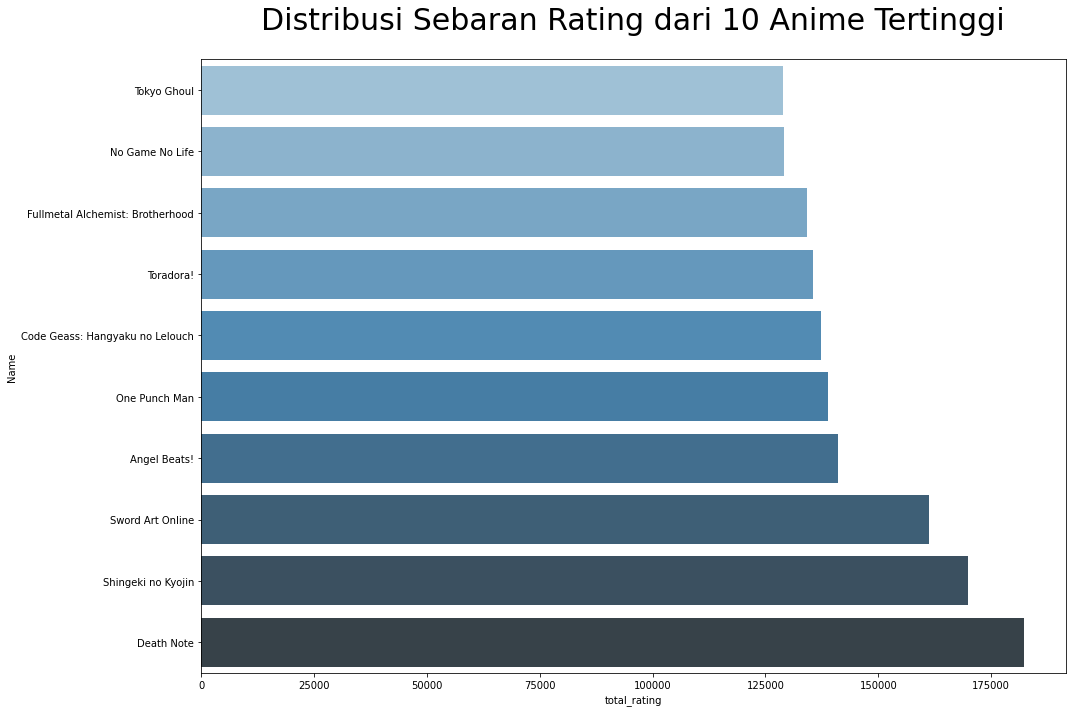

In [31]:
data = rating_anime_count.sort_values(by ='total_rating')

plt.figure(figsize=(15,10))
sns.barplot(data=data.iloc[-10:,:], 
            y='Name', x='total_rating',
            palette="Blues_d")
plt.title('Distribusi Sebaran Rating dari 10 Anime Tertinggi', pad=30, fontsize=30)
plt.tight_layout()
plt.show()

In [32]:
df_anime_clean.dropna(axis=0, inplace=True)
df_rating.dropna(axis=0, inplace=True)

In [33]:
df_rating = df_rating.sort_values('user_id').astype('int')

In [34]:
df_anime_clean.drop_duplicates(subset=['Name'], keep='first', inplace=True)
df_rating.drop_duplicates(subset=['user_id','anime_id'], keep='first', inplace=True)

In [35]:
merge_df = pd.merge(df_rating, df_anime_clean, how='left', on='anime_id')
merge_df

,user_id,anime_id,rating,Name,Genres
0,0,430,9,Fullmetal Alchemist: The Conqueror of Shamballa,"Military, Comedy, Historical, Drama, Fantasy, ..."
1,0,415,10,Tonari no Yamada-kun,"Slice of Life, Comedy"
2,0,2236,10,Toki wo Kakeru Shoujo,"Adventure, Drama, Romance, Sci-Fi"
3,0,448,5,Tenjou Tenge: The Ultimate Fight,"Adventure, Drama, Martial Arts, Romance, Shoun..."
4,0,2034,8,Lovely★Complex,"Comedy, Romance, Shoujo"
...,...,...,...,...,...
57633273,353404,223,9,Dragon Ball,"Adventure, Comedy, Fantasy, Martial Arts, Shou..."
57633274,353404,897,7,Dragon Ball Z Movie 04: Super Saiyajin da Son ...,"Action, Adventure, Fantasy, Sci-Fi, Shounen"
57633275,353404,243,7,Gravitation,"Comedy, Music, Romance, Shoujo, Shounen Ai"
57633276,353404,287,9,Grappler Baki (TV),"Action, Sports, Martial Arts, Shounen"


In [ ]:
merge_df = merge_df[~pd.isnull(merge_df['Genres'])]
merge_df.shape